# In which I implement a very aggressively named algorithm. 
Recently I found myself needing to solve a second order ODE with some slightly messy boundary conditions and after struggling for a while I ultimately stumbled across the numerical **shooting method**. Below is an example of a similar problem and a python implementation for solving it with the shooting method. 

The shooting method works for solving problems of the form $\frac{d\vec{y}}{dt} = f(t, \vec{y})$ where rather than having $\vec{y}$ fully specified at some $t$ (an initial value problem) we instead have various components of $\vec{y}$ specified at different $t$ (a boundary value problem). For boundary value problems (BVP) the boundary conditions can be Dirichlet, Neumann or mixed and the shooting method can handle them all!

# Example: Steady State Heat Equation
The quasi-one-dimensional steady state approximation to the general [heat equation](https://en.wikipedia.org/wiki/Heat_equation) is an ordinary differential equation (ODE) in the temperature, $T$, that also depends on the area as a function of position, $A(x)$. For this example we have a physical system which is a metal nanowire of length $L=20$ nm coupled on the left to a heat sink and coupled on the right to a constant-power heat source. Thus the boundary constraints on the solution to this steady state problem are that the temperature on the left boundary is pinned to the environmental temperature, $T_E$, (a Dirichlet condition) while on the right hand side we know the influx of heat energy per unit area. This latter condition can be cast in terms of the temperature gradient (so a Neumann condition) by Fourier's Law, which states that the rate of heat flow is proportional to the spatial gradient of the temperature:

\begin{align*}
\textrm{Fouriers Law:} \qquad \frac{dQ}{dt} = -\kappa(A\frac{dT}{dx}).
\end{align*}

In Fourier's law $\kappa$ is a material-dependent thermal conductivity. The full boundary value problem is thus

\begin{align*}
\textrm{differential equation} \qquad \frac{d^2T}{d x^2} + \big(\frac{1}{A}\frac{dA}{dx}\big)\frac{dT}{dx} = 0,\\[1em]
\textrm{boundary condition 1} \qquad T(0) = T_E \\[1em]
\textrm{boundary condition 2} \qquad \frac{dT}{dx}\biggr|_L = \frac{p_c}{\kappa \: A(L)}.
\end{align*}

Here $p_c$ is the power influx from the constant power heat source in units of Watts. Depending on the expression $A(x)$ this may not be analytically soluble, and the mixed boundary conditions add some additional complications, so let's develop a numerical approach.

First cast the second order ODE into a coupled system of two first order ODE's:

\begin{align*}
y' = \frac{dy}{dx}\\
\frac{dy'}{dx} = f(x, y') = -\big(\frac{1}{A}\frac{dA}{dx}\big)y'.
\end{align*}

More succinctly these two equations can be written as a single vector ODE:

\begin{align*}
\frac{d\vec{z}}{dx} = f(x, \vec{z}) \:, \qquad
    \vec{z} &= \begin{bmatrix}
           y \\
           y' \\
         \end{bmatrix} \:, \qquad
    f(x, \vec{z}) = \begin{bmatrix}
           y' \\
           -\big(\frac{1}{A}\frac{dA}{dx}\big)y'\\
           \end{bmatrix}
 \end{align*}
         
In this case our mixed boundary conditions tell us the following:

\begin{align*}
    \vec{z}(0) &= \begin{bmatrix}
           T_E \\
           ? \\
         \end{bmatrix} \:, \qquad
    \vec{z}(L) = \begin{bmatrix}
           ? \\
            \frac{p_c}{\kappa \: A(L)}\\
           \end{bmatrix}
 \end{align*}

Now the ODE tells us the derivative of $\vec{z}$ at any point if we know it's value, and a derivative lets us calculate the value at a neighboring point relative to the value at the current point. That means if we had a correct value for $\vec{z}$ at an endpoint then we could propagate this information over to the other boundary, but unfortunately our values of $\vec{z}$ at the boundaries are incomplete. **The essence of the shooting method is to guess a complete $\vec{z}$ at one endpoint, use the relationship for $\frac{d\vec{z}}{dx}$ to propagate a solution to $\vec{z}(x)$ over to the other endpoint, and then compare how close the propagated solution is to known solution in the second boundary condition.** You then update your guess and repeat the process to converge the propagated solution to the true solution at the other boundary. 

### Shooting Method Resources
- [official docs for `scipy.integrate.ode`, a multipupose numerical integrator for expressions of the form $y' = f(t, y)$.](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.integrate.ode.html#hnw93)
- [python implementation of shooting method for boundary conditions $y(0) = \alpha$ and $y(L) = \beta$](http://www.math-cs.gordon.edu/courses/mat342/python/bvp.py) 
- [stack overflow question about solving a second order ODE by turning it into a system of two first order ODEs.](http://stackoverflow.com/questions/19779217/need-help-solving-a-second-order-non-linear-ode-in-python)
- [incredibly clear lecture notes on the shooting method and how to implement it.](https://web.stanford.edu/~fringer/teaching/numerical_methods_02/handouts/lecture9.pdf)
- [good notes on the shooting method with a somewhat different interpretation and approach](http://www.cems.uvm.edu/~tlakoba/math337/notes_7.pdf)

# Numerical Implementation of Shooting
The process of propagating is essentially the process of integrating as you are using the value of the derivative at each point to produce the value of the function at the next point. There are various tools for numerical integration but we will use the very convenient and general `scipy.integrate.ode` which lets you [choose from a variety of specific numerical integration algorithms](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.ode.set_initial_value.html). In particular we will use the Runge-Kutta algorithm. 

The Runge-Kutta algorithm expects you to pass it a function that computes the derivative at any point, $\vec{z}' = f(x,\vec{z})$ (vector-valued for a system of coupled equations), so we will implement this as a small function. Then we will write a wrapper that takes an initial value $\vec{z}(0)$ and calls the Runge-Kutta algorithm repeatedly to integrate across the full domain This function will return a list of $\vec{z}$ values which is the integrated solution for the discretized points in the domain. Finally we will write an optimization wrapper that actually solves the problem i.e. finds the optimal value for $y'(0) = \big(\vec{z}(0)\big)_2$ where loss is the squared error between the propagated $y'(L)$ and the true $y'(L)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import snips as snp
snp.prettyplot(matplotlib)
from scipy.optimize import least_squares
from scipy.integrate import ode

%matplotlib inline

In [2]:
def compute_area_areaprime(x):
    """
    Compute the area and it's derivative as a function of independent variable x, return them as a vector.
    
    :param x: independent variable, the domain of the problem is x=0 to L
    :return: a 2-vec holding [A, dA/dx].
    """
    return [10, 0]  # Rectangle geometry


def compute_zprime(x, z, areafunction):
    """
    Compute the value of the vector z's derivative at a point given the value of the vector function z and the
    independent variable x. The form of this calculation is specified by the vector ODE. Return a vector for the
    derivative.
    
    :param x: indpendent variable, the domain of the problem is x=0 to L
    :param z: 2-vec of the variable representing system of equations, z = [y, y']
    :param areafunction: a function that takes x and gives back a 2-vec [A(x), dA(x)/dx]
    :return: 2-vec of values for z' = f(x, z)
    """
    zprime_0 = z[1]
    area, areaprime = areafunction(x)
    zprime_1 = - areaprime/area * z[1]
    return [zprime_0, zprime_1]


def integrate_over_domain(z_at_0, integrator, areafunction, length=10, step=0.1, silent=True):
    """
    Call runge-kutta repeatedly to integrate the vector function z over the full domain (specified by length). Return
    a list of 2-vecs which are the value of the vector z at every point in the domain discretized by 'step'. Note that
    runge-kutta object calls x as "t" and z as "y".
    
    :param z_at_0: the value of the vector z=[y, y'] at the left boundary point. should be list or array.
    :param integrator: the runge-kutta numerical integrator object
    :param areafunction: a function that takes x and gives back a 2-vec [A(x), dA(x)/dx]
    :param length: the length of the domain to integrate on
    :param step: the step size with which to discretize the domain
    :param silent: bool indicating whether to print the progress of the integrator
    :return: array of 2-vecs - the value of vector z obtained by integration for each point in the discretized domain.
    """
    initial_conditions = z_at_0
    integrator.set_initial_value(initial_conditions, t=0)  # Set the initial values of z and x
    integrator.set_f_params(areafunction)
    dt = step

    xs, zs = [], []
    while integrator.successful() and integrator.t <= length:
        integrator.integrate(integrator.t + dt)
        xs.append(integrator.t)
        zs.append([integrator.y[0], integrator.y[1]])
        if not silent:
            print("Current x and z values: ", integrator.t, integrator.y)
    return xs, zs


def solve_bvp_pj(y_at_0, yprime_at_length, areafunction, length=10, step=0.1, silent=True):
    """
    Numerically find the value for y'(0) that gives us a propagated (integrated) solution matching most closely with
    with other known boundary condition y'(L) which is proportional to the power dissipated by the junction.
    
    :param y_at_0: the known boundary condition on y for the left point.
    :param yprime_at_length: the known boundary condition on y' for the right point
    :param areafunction: a function that takes x and gives back a 2-vec [A(x), dA(x)/dx]
    :param length: the length of the domain to integrate on
    :param step: the step size with which to discretize the domain
    :param silent: bool indicating whether to print the progress of the integrator
    :return: the optimized estimate of y' at the left boundary point giving the most accurate integrated solution.
    """
    integrator = ode(compute_zprime).set_integrator("dopri5")
    z_at_0 = [y_at_0, 0.5]  # Make an initial guess for yprime at x=0

    def residuals(yprime_at_0, y_at_0, yprime_at_length):

        # Use RK to compute [y, y'] over the domain given the values for y, y' at the boundary
        z_at_0 = [y_at_0, yprime_at_0]
        xs, zs = integrate_over_domain(z_at_0, integrator, areafunction)
        yprime_at_length_integrated = np.array(zs)[-1, 1]

        # Return the difference between y'(L) found by numerical integrator and the true value
        return yprime_at_length - yprime_at_length_integrated

    yprime_at_0_guess = 0.2
    lsq = least_squares(residuals, yprime_at_0_guess, args=(y_at_0, yprime_at_length), loss="soft_l1")
    yprime_at_0_estimate = lsq.x[0]
    return yprime_at_0_estimate

Notice we defined our functions to take the area function as an input so that we can easily vary the geometry. For the rectangular geometry, $A(x) = \alpha$ for some constant $\alpha$, this ODE has a simple analytical solution in which $T(x)$ varies linearly from the pinned value $T(0) = T_E$ to a maximum on the right boundary point, $T(L) = T_E + \frac{pL}{\kappa}$. 

Let's plot the solution $T(x)$ for different geometries, including the known rectangular solution as a sanity check:

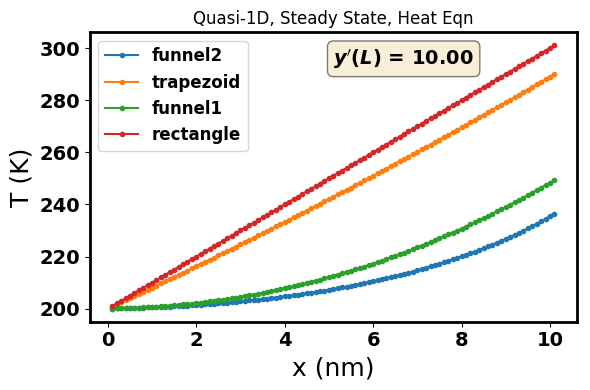

In [3]:
areafuncs = {"funnel1": lambda x: [20/(x+2) - 0.166, -20/(x+1)**2],
             "funnel2": lambda x: [10/(x+1) - 0.59, -10/(x+1)**2],
             "trapezoid": lambda x: [10-0.2*x, -0.2],
             "rectangle": lambda x: [10, 0]
             }
integrator = ode(compute_zprime).set_integrator("dopri5")
yprime_at_length = 10
y_at_0 = 200
fig, ax = plt.subplots()
snp.labs("x (nm)", "T (K)", "Quasi-1D, Steady State, Heat Eqn")
for nm, areaf in areafuncs.items():
    integrator.set_initial_value([y_at_0, 0.5], t=0)  # Set the initial values of z and x
    integrator.set_f_params(areaf)
    yprime_at_0_estimate = solve_bvp_pj(y_at_0, yprime_at_length, areaf)
    xs, zs = integrate_over_domain([y_at_0, yprime_at_0_estimate], integrator, areaf)
    ax.plot(xs, np.array(zs)[:,0], label=nm)

ax.legend(loc="best")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.5, 0.95, "$y'(L)$ = %.2f" % (yprime_at_length,), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()

If instead of the power dissipated through the right boundary our constraints told us $T(L) = T_j$ then we would only need to alter the outermost wrapper so that the least squares minimization considers the residuals between the propagated $T(L)$ and $T_j$. This would let us solve for the power needed to sustain a particular right-hand boundary temperature for different left-hand boundary temperatures (environmental temperatures).

In [4]:
def solve_bvp_tj(y_at_0, y_at_length, areafunction, length=10, step=0.1, silent=True):
    """
    Numerically find the value for y'(0) that gives us a propagated (integrated) solution matching most closely with
    with other known boundary condition y(L) which is proportional junction temperature.

    :param y_at_0: the known boundary condition y(0) for the left point.
    :param y_at_length: the known boundary condition y(L) for the right point
    :param areafunction: a function that takes x and gives back a 2-vec [A(x), dA(x)/dx]
    :param length: the length of the domain to integrate on
    :param step: the step size with which to discretize the domain
    :param silent: bool indicating whether to print the progress of the integrator
    :return: the optimized estimate of y' at the left boundary point giving the most accurate integrated solution.
    """
    integrator = ode(compute_zprime).set_integrator("dopri5")
    z_at_0 = [y_at_0, 0.5]  # Make an initial guess for yprime at x=0

    def residuals(yprime_at_0, y_at_0, y_at_length):
        # Use RK to compute [y, y'] over the domain given the values for y, y' at the boundary
        z_at_0 = [y_at_0, yprime_at_0]
        xs, zs = integrate_over_domain(z_at_0, integrator, areafunction)
        y_at_length_integrated = np.array(zs)[-1, 0]

        # Return the difference between y'(L) found by numerical integrator and the true value
        return y_at_length - y_at_length_integrated

    yprime_at_0_guess = 0.2
    lsq = least_squares(residuals, yprime_at_0_guess, args=(y_at_0, y_at_length), loss="soft_l1")
    yprime_at_0_estimate = lsq.x[0]
    return yprime_at_0_estimate

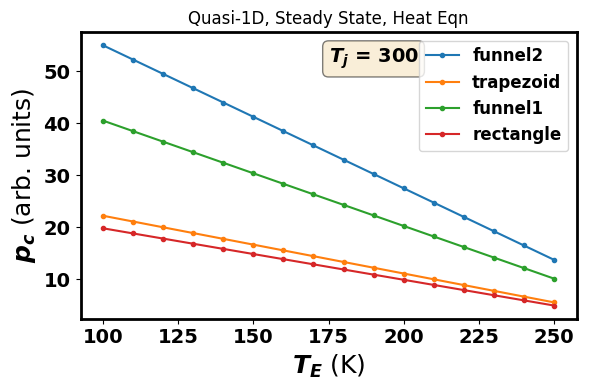

In [5]:
integrator = ode(compute_zprime).set_integrator("dopri5")
y_at_length = 300
fig, ax = plt.subplots()
snp.labs("$T_E$ (K)", "$p_c$ (arb. units)", "Quasi-1D, Steady State, Heat Eqn")
tenvs = np.arange(100, 260, 10)
for nm, areaf in areafuncs.items():
    pjs = []
    for y_at_0 in tenvs:
        integrator.set_initial_value([y_at_0, 0.5], t=0)  # Set the initial values of z and x
        integrator.set_f_params(areaf)
        yprime_at_0_estimate = solve_bvp_tj(y_at_0, y_at_length, areaf)
        xs, zs = integrate_over_domain([y_at_0, yprime_at_0_estimate], integrator, areaf)
        pjs.append(np.array(zs)[-1,1])
    ax.plot(tenvs, pjs, label=nm)

ax.legend(loc="best")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.5, 0.95, "$T_j$ = %.0f" % (y_at_length,), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()